In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Create the toy problem

def toy_problem(n=1000, A=.3, B=2):
  # Create noise
  X = np.random.uniform(0, 1, (n,1)).astype(np.float32)

  # define function
  y = A*np.sin(B*np.pi*X) + np.random.uniform(-.1, .1, size=(n,1)).astype(np.float32) + X

  # Make Test Data
  x = np.linspace(0, 1, n).reshape(-1,1).astype(np.float32)

  return X, y, x

In [0]:
X, y, x = toy_problem(4000)

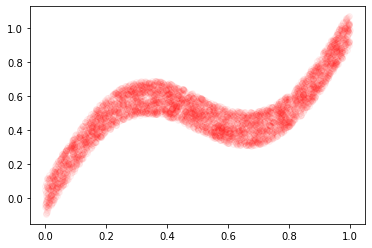

In [10]:
plt.figure()
plt.plot(X, y, 'ro', alpha=.04)

In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
from copy import deepcopy

# Are we executing eagerly
tf.executing_eagerly()

True

In [0]:
#build Dense NN
def build_model(h=16, lr=1e-3):
  #Start with an input
  input = tf.keras.layers.Input(shape=(1,))

  #Now put Dense Layers on top
  x = tf.keras.layers.Dense(h, activation='tanh')(input)

  # Out put 1 value
  x = tf.keras.layers.Dense(1, activation=None)(x)

  #Define optimizer
  optimizer = tf.optimizers.Adam(learning_rate=lr)

  #Define loss function
  loss = tf.losses.MeanSquaredError()

  #Make the model
  model = tf.keras.models.Model(input, x)
  model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
  return model

In [0]:
m = build_model()

In [0]:
history = m.fit(X, y, epochs=200, verbose=0)

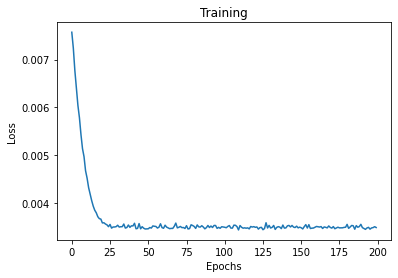

In [19]:
# Plot the loss history
plt.plot(range(200), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training')
plt.show()

In [0]:
# Now we can predict using 
pred = m.predict(x)

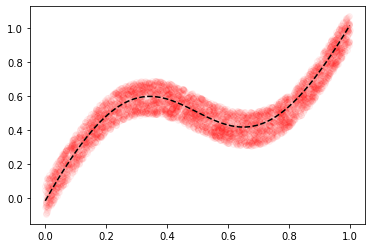

In [21]:
plt.figure()
plt.plot(x, pred, '--k', zorder=2.5)
plt.plot(X, y, 'ro', alpha=.04)

In [0]:
# Now we want to consider the inverse case. 

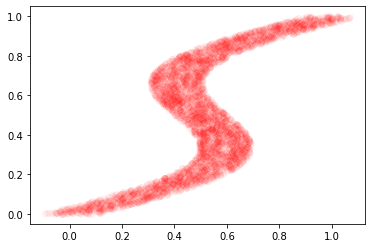

In [23]:
plt.figure()
plt.plot(y,X, 'ro', alpha=.04)

In [0]:
X_inv = y
y_inv= X

m = build_model()
history=m.fit(X_inv, y_inv, epochs=200, verbose=0)

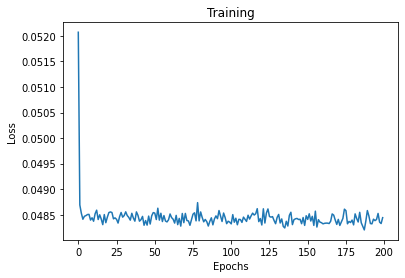

In [25]:
# Plot the loss history
plt.plot(range(200), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training')
plt.show()

In [0]:
pred = m.predict(x)

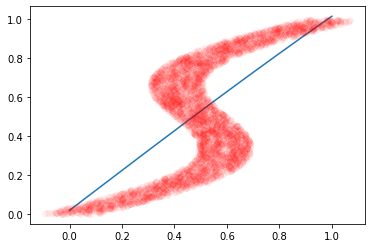

In [27]:
plt.figure()
plt.plot(x, pred)
plt.plot(y,X, 'ro', alpha=.04)

In [0]:
tf.config.experimental_run_functions_eagerly(True)

In [0]:
# Clearrrrrrly its not working But we can adust our model to work for it

  
def MDN_loss(y_true, mean, var, mixing):
  # First find PDF
  pdf = PDF(y_true, mean, var)
  out = tf.multiply(pdf, mixing)
  out = tf.reduce_sum(out, 1, True)
  out = -tf.math.log(out)
  return tf.reduce_mean(out)

  return loss
def PDF(y_true, mean, var):
  pdf = tf.subtract(y_true, mean)**2
  pdf = tf.multiply(1/tf.math.sqrt(2*np.pi*var) , tf.math.exp(-pdf/2/var))

  return pdf

def build_MDN(input_features=1, gaussians=10, h=100, lr=1e-3):
  #Start with an input
  input = tf.keras.layers.Input(shape=(input_features,))

  #Now put Dense Layers on top
  base = tf.keras.layers.Dense(h, activation='tanh', name='BASE')(input)

  mean = tf.keras.layers.Dense((input_features*gaussians), activation=None, name='MEAN')(base)
  variance_init = tf.keras.layers.Dense(gaussians, activation=None, name='VAR_INIT')(base)
  variance = tf.keras.layers.Lambda(lambda sig: tf.exp(sig), output_shape=gaussians, name='VAR')(variance_init)
  mixing = tf.keras.layers.Dense(gaussians, activation='softmax', name='MIXING')(base)


  #Make the model
  model = tf.keras.models.Model(input, outputs=[mean, variance, mixing])
  return model
# NOw we need to define a training step to use the loss function
@tf.function
def train_step(model, optimizer, train_x, train_y):
  # Gradient tape traces operations like vmad
  with tf.GradientTape() as tape:
    mean_, var_, mixing_= model(train_x, training=True)
    loss = MDN_loss(train_y, mean_, var_, mixing_)

  # Now use tape to compute the gradient and descend
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

In [0]:
# Lets build a big ole dataset with tons of examples to train on
N = X_inv.shape[0]
data_set = tf.data.Dataset.from_tensor_slices((X_inv, y_inv)).shuffle(N).batch(N)

In [47]:
losses = []
epochs = 1000
optimizer = tf.optimizers.Adam(learning_rate=.001)
m = build_MDN(gaussians=24, h=50)

for epoch in range(epochs):
  for train_x, train_y in data_set:
    loss = train_step(m, optimizer, train_x, train_y)
    losses.append(loss)
  if epoch%100==0:
    print(f'{epoch}/{epochs} loss val: {loss}')

0/1000 loss val: 1.0723810195922852
100/1000 loss val: 0.15852448344230652
200/1000 loss val: -0.4736492335796356
300/1000 loss val: -0.6766505241394043
400/1000 loss val: -0.7767428159713745
500/1000 loss val: -0.8190693259239197
600/1000 loss val: -0.8554721474647522
700/1000 loss val: -0.8865866661071777
800/1000 loss val: -0.9162580370903015
900/1000 loss val: -0.9402222633361816


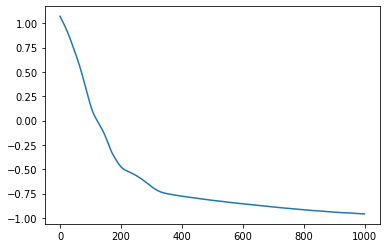

In [48]:
plt.figure()
plt.plot(range(epochs), losses)

In [0]:
means, variances, mixings = m.predict(x)

In [50]:
mixings.shape

(4000, 24)

In [0]:
# Now we want to make a function that will sample from all the gaussians to recreate our plot

def re_sample(mean, var, mix, input_features=1, n_samples=20):
  n,k = mix.shape
  l = input_features

  #Output grid
  grid = np.zeros((n, n_samples, l))
  for i in range(n):
    for j in range(n_samples):
      index = np.random.choice(range(k), p=mix[i])
      for li in range(l):
        grid[i,j,li] = np.random.normal(mean[i, index*(li+l)], np.sqrt(var[i, index]))
  return grid



In [0]:
predictions = re_sample(means, variances, mixings)

In [53]:
predictions.shape

(4000, 20, 1)

(-0.1, 1.1)

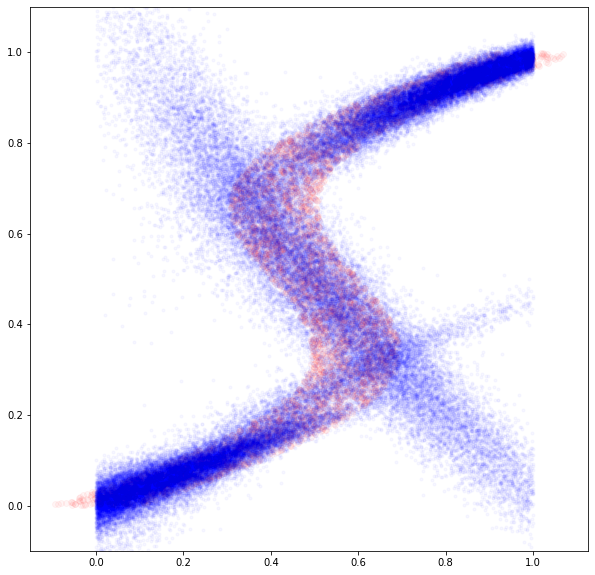

In [54]:
plt.figure(figsize=(10,10))
plt.plot(X_inv, y_inv, 'ro', alpha=.04)
for i in range(predictions.shape[1]):
  plt.plot(x, predictions[:,i], 'b.', alpha=.03)
plt.ylim(-.1, 1.1)

In [0]:
# now trying a different toy model
def toy_model2(N=1000, std=.1, mean=0, amp=1):
  X = np.random.uniform(0, 1, (N,1)).astype(np.float32)
  slope = amp*np.random.normal(mean, std, (N,1)).astype(np.float32)
  y = X*slope+X
  x = np.random.uniform(0, 1, (N,1)).astype(np.float32)
  return X, y, x

In [0]:
X, y, x = toy_model2(N=5000, amp=10)

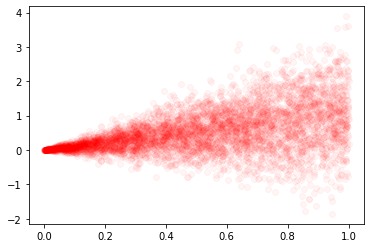

In [275]:
plt.figure()
plt.plot(X, y, 'ro', alpha=.04)

In [0]:
m = build_MDN(gaussians=1)
N = X.shape[0]
data_set = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(N).batch(N)

In [277]:


losses = []
epochs = 1000
optimizer = tf.optimizers.Adam(learning_rate=.001)

for epoch in range(epochs):
  for train_x, train_y in data_set:
    loss = train_step(m, optimizer, train_x, train_y)
    losses.append(loss)
  if epoch%100==0:
    print(f'{epoch}/{epochs} loss val: {loss}')

0/1000 loss val: 1.2511368989944458
100/1000 loss val: 0.8237217664718628
200/1000 loss val: 0.5715739727020264
300/1000 loss val: 0.5227530002593994
400/1000 loss val: 0.5225825905799866
500/1000 loss val: 0.5224502682685852
600/1000 loss val: 0.5222803950309753
700/1000 loss val: 0.5220595002174377
800/1000 loss val: 0.5217664241790771
900/1000 loss val: 0.5213651657104492


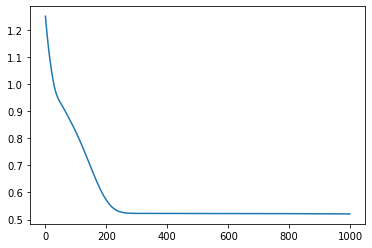

In [278]:
plt.figure()
plt.plot(range(epochs), losses)

In [0]:
mean, variance, mixing = m.predict(x)

In [0]:
avg_mean, avg_vari = np.mean(mean), np.mean(variance)

In [0]:
predictions = re_sample(mean, variance, mixing, n_samples=5 )

In [0]:
def approx_conditional_mode(pi, var, mu):
    n, k = pi.shape
    out_1 = np.zeros((n, 1))
    out_2 = out_1.copy()
    # Get the index of max pi value for each row
    max_component = tf.argmax(pi, axis=1)
    for i in range(n):
        # The mean value for this index will be used
        mc = max_component[i].numpy()
        for j in range(1):
            out_1[i, j] = mu[i, mc*(1+j)]
            out_2[i, j] = var[i, mc*j]
    return out_1, np.sqrt(out_2)

In [0]:
test_m, test_var = approx_conditional_mode(mixing, variance, mean)

In [284]:
test_var.shape

(5000, 1)

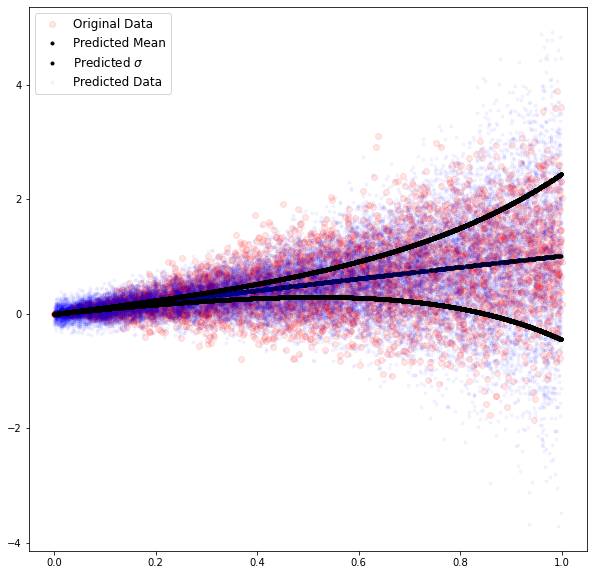

In [287]:
plt.figure(figsize=(10,10))
plt.plot(X, y, 'ro', alpha=.1, label='Original Data')
plt.plot(x[::5], test_m[::5], 'k.', label='Predicted Mean')
plt.plot(x, test_var*x+x, '.', color='k', label=r'Predicted $\sigma$', zorder=2.5)
plt.plot(x, -test_var*x+x, '.', color='k', zorder=2.5)
for i in range(predictions.shape[1]):
  if i==1:
    plt.plot(x, predictions[:,i], 'b.', alpha=.04, label='Predicted Data')
  else:
    plt.plot(x, predictions[:,i], 'b.', alpha=.04)

plt.legend(fontsize=12)
